In [1]:
import numpy as np 
import pandas as pd
from src import utils, redcells, db
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
dbase = db.get_sessions()
example = dbase.query("mname == 'VG11' & datexp == '2024_10_15'")

In [4]:
name, datexp, blk = example['mname'].values[0], example['datexp'].values[0], example['blk'].values[0]

In [3]:
ROOT_PATH = "Z:/data/PROC"
RET_PATH = "D:/retinotopy/aligned_xy/behav"
MDL_PATH = "C:/Users/labadmin/Documents/category-neural/data" # we don't have models there, so it will create a new one.

Example loading of a mouse object:

In [15]:
m1 = utils.load_mouse(name, datexp, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, 
                      data_path=ROOT_PATH, ret_path=RET_PATH,  mdl_path=MDL_PATH, opt_tlag = 1)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
    .rename(columns = {'index':'frame'})
    .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
    .set_index('frame'))

green_channel = Path(ROOT_PATH).joinpath(name, datexp, blk, "suite2p")
m1.isred = redcells.get_redcells(green_channel) # the corrected redcells.npy
# lets filter out cells with low snr
m1.isred = m1.isred[m1._snr>=.25]
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]
m1._snr = m1._snr[m1._snr>=.25]
# lets get the interpolated spks
clear_output(wait=True)

Checking if model object exists ...
Timeline with fname: Timeline_VG11_2024_10_15_4.mat not found, trying with fname: VG11_2024_10_15_4.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [05:56<00:00, 17.84s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG11_2024_10_15_4_behav.npz
(28508, 2)


## Difference between cell types in fr and variance 

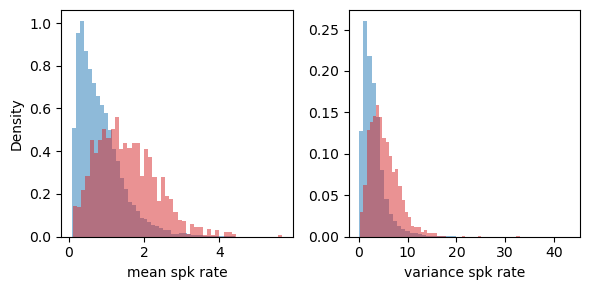

In [17]:
mean = m1._spks.mean(axis=1)
var = m1._spks.var(axis=1)

plt.figure(figsize=(6, 3))
ex = np.logical_not(m1.isred[:,0]).astype(bool)
inh = m1.isred[:,0].astype(bool)
plt.subplot(121)
plt.hist(mean[ex], bins=50, alpha=0.5, label='excitatory cells', color='tab:blue', density=True);
plt.hist(mean[inh], bins=50, alpha=0.5, label='inhibitory cells', color='tab:red', density=True);
plt.xlabel("mean spk rate")
plt.ylabel("Density")
plt.subplot(122)
plt.hist(var[ex], bins=50, alpha=0.5, label='excitatory cells', color='tab:blue', density=True);
plt.hist(var[inh], bins=50, alpha=0.5, label='inhibitory cells', color='tab:red', density=True);
plt.xlabel("variance spk rate")
plt.tight_layout()

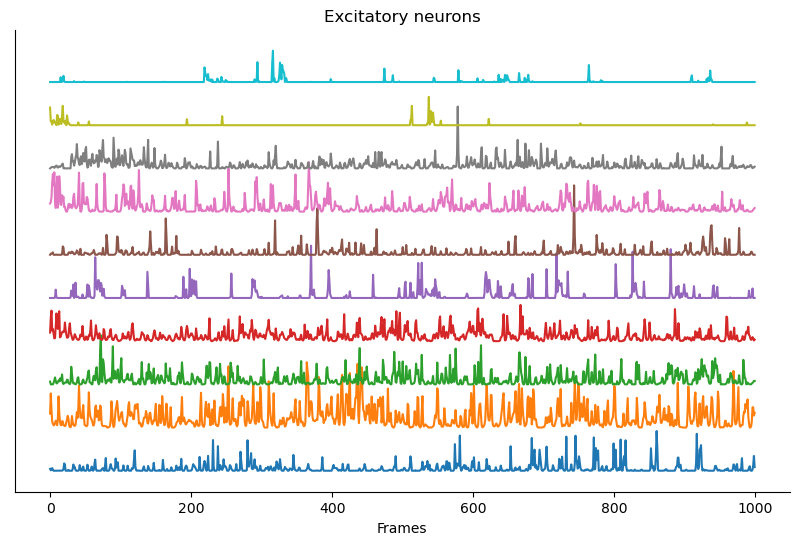

In [18]:
plt.figure(figsize=(10, 6))
# pick 10 random neurons and plot their spikes
ex_n = m1._spks[ex]
inh_n = m1._spks[inh]
neurons = np.random.choice(ex_n.shape[0], 10)
plt.title("Excitatory neurons")
for i, n in enumerate(neurons):
    plt.plot(ex_n[n,:1000] + (i) *10)
plt.xlabel('Frames')
plt.ylabel("")
plt.yticks([])
sns.despine()
plt.show()

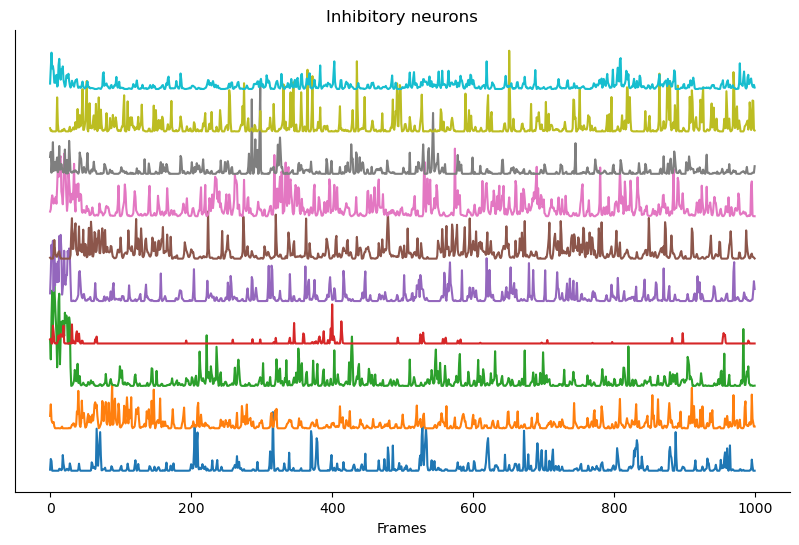

In [19]:
plt.figure(figsize=(10, 6))
neurons = np.random.choice(inh_n.shape[0], 10)
plt.title("Inhibitory neurons")
for i, n in enumerate(neurons):
    plt.plot(inh_n[n,:1000] + (i) *10)
plt.xlabel('Frames')
plt.ylabel("")
plt.yticks([])
sns.despine()
plt.show()

# Looks good, lets build all the objs that will be reutilized later, this process takes a while, but will save a lot of time later

In [9]:
for i, row in dbase.iterrows():
    name, date, blk = row['mname'], row["datexp"], row["blk"]
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, 
                        data_path=ROOT_PATH, ret_path=RET_PATH,  mdl_path=MDL_PATH, opt_tlag = 1)
    frameselector = utils.get_frameselector(m1)
    istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
    istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
    m1.frameselector = (frameselector.reset_index()
        .rename(columns = {'index':'frame'})
        .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
        .set_index('frame'))

    green_channel = Path(ROOT_PATH).joinpath(name, date, blk, "suite2p")
    m1.isred = redcells.get_redcells(green_channel) # the corrected redcells.npy
    # lets filter out cells with low snr
    m1.isred = m1.isred[m1._snr>=.25]
    m1._spks = m1._spks[m1._snr>=.25]
    m1._xpos = m1._xpos[m1._snr>=.25]
    m1._ypos = m1._ypos[m1._snr>=.25]
    m1._iplane = m1._iplane[m1._snr>=.25]
    m1.iarea = m1.iarea[m1._snr>=.25]
    m1.iregion = m1.iregion[m1._snr>=.25]
    m1.xy_t = m1.xy_t[m1._snr>=.25]
    m1._snr = m1._snr[m1._snr>=.25]
    m1.trial_dict = utils.get_trialno_bytype(m1.frameselector) #trial_no dict
    # lets get the interpolated spks
    for zscored in [True, False]:
        print("saving zscored version" if zscored else "saving not zscored version") 
        m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = zscored, corridor_length=400)
        save_path = r"D:\mouseobj" if zscored else r"D:\mouseobj\notz"
        utils.compute_dprime(m1, discrimination_region = (0,100), corridor_length = 400, nogray = False)
        utils.save_mouse(m1, compressed=False, mdl_path=save_path)
    clear_output(wait=True)

Checking if model object exists ...
Timeline with fname: Timeline_VG15_2024_11_01_3.mat not found, trying with fname: VG15_2024_11_01_3.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [05:37<00:00, 16.87s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG15_2024_11_01_3_behav.npz
(23298, 2)
saving zscored version
39 14749
interpolating 20669 neurons, 14711 frames to
the vector of distance with shape: (14711,)
neurons: 20669, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\VG15\2024_11_01\3
saving not zscored version
39 14749
interpolating 20669 neurons, 14711 frames to
the vector of distance with shape: (14711,)
neurons: 20669, trials: 399, corridor length: 400
dprime saved in MouseObject.train_dp (neurons) using even trials
Mouse object saved to D:\mouseobj\notz\VG15\2024_11_01\3


In [10]:
def compute_cell_change(name, date, blk, tsh=1):
    areas = ["V1", "medial", "lateral", "anterior"]
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    ncells, ntrials = m1.interp_spks.shape[0], m1.interp_spks.shape[1]
    ctypes = 2
    cod_dirs = np.empty((ntrials, len(areas), ctypes, 400)) #ntrials x areas x redcell x positions
    proportion = np.empty((len(areas), 2, 2))
    selective_cells = np.empty((4,2,2, ncells))
    main_dir = Path(f"../data/{name}/{date}/{blk}")
    if not main_dir.exists():
        main_dir.mkdir(parents=True)
    for indexa, area in enumerate(areas):
        ia = utils.get_region_idx(m1.iarea, area)
        for redcell in range(ctypes):
            if redcell == 0: 
                selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
            else:
                selected_type = m1.isred[:,0].astype(bool)
            # proportion of cells changing 
            prefer_r_1 = (m1.train_dp>=tsh)
            prefer_nr_1 = (m1.train_dp<=-tsh)
            area_prefer_r_1 = prefer_r_1 * ia * selected_type
            area_prefer_nr_1 = prefer_nr_1 * ia * selected_type
            proportion[indexa,redcell,0] = (area_prefer_r_1.sum()) / (ia * selected_type).sum()
            proportion[indexa,redcell,1] = (area_prefer_nr_1.sum()) / (ia * selected_type).sum()
    np.save(main_dir / "proportion_cells_0_100_1tsh.npy", proportion)

In [11]:
for i, row in dbase.iterrows():
    name, date, blk = row['mname'], row["datexp"], row["blk"]
    compute_cell_change(name, date, blk, tsh=1)
    clear_output(wait=True)
print("Proccessing done")

Proccessing done


Let's load the cells per session type 

In [16]:
session_types = dbase["session"].unique()
prop_cells = np.empty((len(session_types), 4, 4, 2, 2)) # session x mice x areas x redcell x proportion
for iss, session in enumerate(session_types):
    dbase_session = dbase.query(f"session == '{session}'")
    dbase_session = dbase_session.reset_index(drop=True)
    for i, row in dbase_session.iterrows():
        name, date, blk = row['mname'], row["datexp"], row["blk"]
        prop_day = np.load(Path(f"../data/{name}/{date}/{blk}/proportion_cells_0_100_1tsh.npy"))
        prop_cells[iss, i, :, :, :] = prop_day

# lets compute the coding dirs per session type

In [4]:
areas = ["V1", "medial", "lateral", "anterior"]
ctypes = ["exc", "inh"]
corridor_length = 400
main_dir = Path(f"../data/overall")

def select_neurons(m1, area: str, celltype:str, dprime = None, dptsh=95):
    ia = utils.get_region_idx(m1.iarea, area)
    assert celltype in ['exc', 'inh'], "celltype must be either 'exc' or 'inh'"
    selected_type = np.logical_not(m1.isred[:,0]).astype(bool) if celltype == 'exc' else m1.isred[:,0].astype(bool)
    if dprime is None:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=dptsh) #tresh based on the area
    else:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dprime[ia*selected_type], tsh=dptsh)
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia * selected_type
    area_prefer_nr = prefer_nr * ia * selected_type
    return area_prefer_r, area_prefer_nr, selected_type, ia



# zscored coding dirs

In [6]:
session_types = dbase["session"].unique()
session_folder_names = ["all_first", "first_training", "last_training", "all_last"]
main_dir = Path(f"../data/overall")
for iss, session in enumerate(session_types):
    print(f"Processing session {iss+1}/{len(session_types)}: {session}")
    dbase_session = dbase.query(f"session == '{session}'")
    dbase_session = dbase_session.reset_index(drop=True)
    cds = np.empty((dbase_session.shape[0], 4, len(areas), len(ctypes), corridor_length)) # mice, ttype, areas, cell types, positions
    for im, row in dbase_session.iterrows():
        name, date, blk = row['mname'], row["datexp"], row["blk"]
        m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
        protA = m.trial_dict["rewarded"][1::2]
        protB = m.trial_dict["non rewarded"][1::2]
        restA = m.trial_dict["rewarded test"]
        restB =  m.trial_dict["non rewarded test"]
        ## Dprime selection trials
        trial_split = {"rewarded": protA, "non rewarded": protB, "rewarded test": restA, "non rewarded test": restB}
        for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
            for ct, c_type in enumerate(["exc", "inh"]):
                a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type)
                cd = m.interp_spks[a_prefer].mean(0) - m.interp_spks[b_prefer].mean(0)
                for it, trials in enumerate(trial_split.values()):
                    cds[im, it, ia, ct] = cd[trials,:].mean(0)
    # if a folder for the session does not exist, create it
    session_dir = main_dir / session_folder_names[iss]
    if not session_dir.exists():
        session_dir.mkdir(parents=True)
    np.save(session_dir/"cod_dirs_0_100.npy", cds)
    clear_output(wait=True)

Processing session 4/4: all rewarded after
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_01\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_15\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_23\2
E

# not zscored coding dirs

In [21]:
session_types = dbase["session"].unique()
session_folder_names = ["all_first", "first_training", "last_training", "all_last"]
main_dir = Path(f"../data/notz/overall")
for iss, session in enumerate(session_types):
    print(f"Processing session {iss+1}/{len(session_types)}: {session}")
    dbase_session = dbase.query(f"session == '{session}'")
    dbase_session = dbase_session.reset_index(drop=True)
    cds = np.empty((dbase_session.shape[0], 4, len(areas), len(ctypes), corridor_length)) # mice, ttype, areas, cell types, positions
    for im, row in dbase_session.iterrows():
        name, date, blk = row['mname'], row["datexp"], row["blk"]
        m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
        interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True)
        protA = m.trial_dict["rewarded"][1::2]
        protB = m.trial_dict["non rewarded"][1::2]
        restA = m.trial_dict["rewarded test"]
        restB =  m.trial_dict["non rewarded test"]
        ## Dprime selection trials
        trial_split = {"rewarded": protA, "non rewarded": protB, "rewarded test": restA, "non rewarded test": restB}
        for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
            for ct, c_type in enumerate(["exc", "inh"]):
                a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type)
                cd = interp_spks[a_prefer].mean(0) - interp_spks[b_prefer].mean(0)
                for it, trials in enumerate(trial_split.values()):
                    cds[im, it, ia, ct] = cd[trials,:].mean(0)
    # if a folder for the session does not exist, create it
    session_dir = main_dir / session_folder_names[iss]
    if not session_dir.exists():
        session_dir.mkdir(parents=True)
    np.save(session_dir/"cod_dirs_0_100.npy", cds)
    clear_output(wait=True)

Processing session 4/4: all rewarded after
Checking if model object exists ...
Loading mouse object from D:\mouseobj\notz\VG11\2024_11_01\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\notz\VG11\2024_11_15\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\notz\VG14

# example plotting

In [17]:
def plot_cds(day_response, ttype, area, ctype, ax, references=True):
    trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange']
    from scipy.stats import sem
    """ 
    Plot the mean and SEM of the coding direction for a given trial type, area, and cell type.
    Parameters
    ----------
    day_response : np.ndarray
        The coding direction data for the day. Shape: (n_mice, n_trial_types, n_areas, n_cell_types, corridor_length)
    ttype : int
        The trial type index (0: rewarded, 1: non-rewarded, 2: rewarded test, 3: non-rewarded test).
    area : int
        The area index (0: V1, 1: medial, 2: lateral, 3: anterior).
    ctype : int
        The cell type index (0: excitatory, 1: inhibitory).
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    """
    nmice, ntrial_types, nareas, ncelltypes, corridor_length = day_response.shape
    mean_response = np.mean(day_response, axis=0)
    sem_response = sem(day_response, axis=0)
    ax.plot(mean_response[ttype, area, ctype], color=trial_type_palette[ttype], linewidth=1)
    ax.fill_between(np.arange(corridor_length), mean_response[ttype, area, ctype] - sem_response[ttype, area, ctype],
                                mean_response[ttype, area, ctype] + sem_response[ttype, area, ctype],
                                color=trial_type_palette[ttype], alpha=0.2)
    if references:
        ax.axvline(x=150, color='gray', linestyle='--', alpha=0.2)
        ax.axvline(x=300, color='gray', linestyle='--', alpha=0.2)

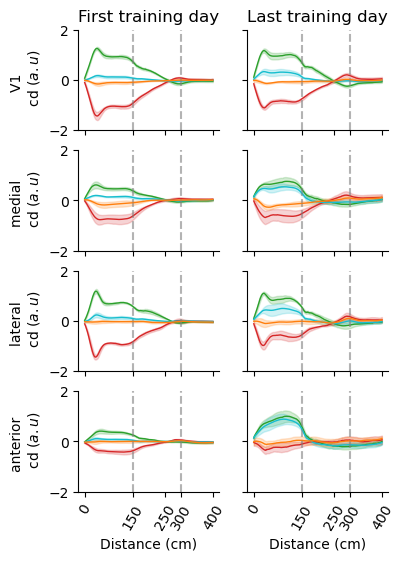

In [27]:
main_dir = Path(f"../data/overall")
"first_training", "last_training"
first_day_cds = np.load(main_dir / "first_training/cod_dirs_0_100.npy")
last_day_matched_cds = np.load(main_dir / "last_training/cod_dirs_0_100.npy")
fig, ax = plt.subplots(4, 2, figsize=(4, 6), sharex=True, sharey=True)
for iday, day_response in enumerate([first_day_cds, last_day_matched_cds]):
    ax[-1,iday].set_xlabel('Distance (cm)')
    ax[-1,iday].set_xticks([0, 150, 250, 300, 400])
    ax[0,iday].set_title("First training day" if iday == 0 else "Last training day")
    for ttype in range(4):
        for a, area in enumerate(areas):
            plot_cds(day_response, ttype, a, 0, ax[a,iday], references=True)
            ax[a,iday].set_ylim(-2,2)
            if iday == 0:
                ax[a,iday].set_ylabel(f"{areas[a]} \n cd $(a.u)$", loc='center')
                #rotate xticks
            for tick in ax[a,iday].get_xticklabels():
                tick.set_rotation(60)
sns.despine()

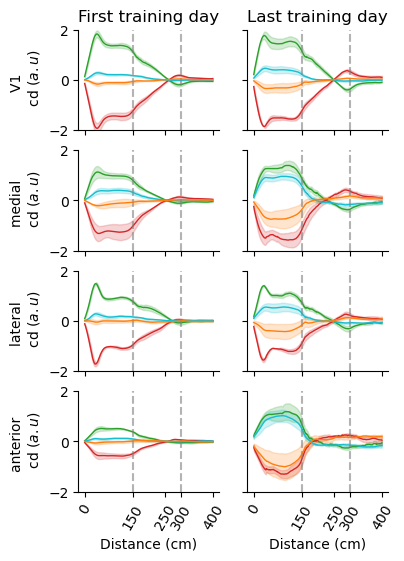

In [29]:
main_dir = Path(f"../data/notz/overall")
"first_training", "last_training"
first_day_cds = np.load(main_dir / "first_training/cod_dirs_0_100.npy")
last_day_matched_cds = np.load(main_dir / "last_training/cod_dirs_0_100.npy")
fig, ax = plt.subplots(4, 2, figsize=(4, 6), sharex=True, sharey=True)
for iday, day_response in enumerate([first_day_cds, last_day_matched_cds]):
    ax[-1,iday].set_xlabel('Distance (cm)')
    ax[-1,iday].set_xticks([0, 150, 250, 300, 400])
    ax[0,iday].set_title("First training day" if iday == 0 else "Last training day")
    for ttype in range(4):
        for a, area in enumerate(areas):
            plot_cds(day_response, ttype, a, 0, ax[a,iday], references=True)
            ax[a,iday].set_ylim(-2,2)
            if iday == 0:
                ax[a,iday].set_ylabel(f"{areas[a]} \n cd $(a.u)$", loc='center')
                #rotate xticks
            for tick in ax[a,iday].get_xticklabels():
                tick.set_rotation(60)
sns.despine()